Vamos a intentar empezar de forma sencilla y para esto no hay nada mejor que usar Tensorflow con las capas de abstracción de Keras, que minimizan sobremanera toda la tarea de definición de nuestra red.

[Keras](https://keras.io/guides/)

Recomendamos abrir estos notebooks en entornos Colab para evitar colapsar nuestros equipos.

[![Abrir en Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/IraitzTB/DS4B2B/blob/main/M3%20-%20Deep%20learning/1.%20Introducción%20a%20Keras%20y%20Tensorflow.ipynb)

Y si no tuviéramos instaladas las librerías necesarias proceder con la siguiente celda (Tensorflow de momento solo soporta hasta la versión 3.12 de Python).

In [ ]:
#!pip install tensorflow keras

Empezamos importando librerías necesarias con sus acrónimos correspondientes.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np

## Datos

Cargamos los datos de MNIST (dígitos). 

No vamos a tratar imágenes con redes convolucionales de momento (perdemos la estructura espacial 2D). Todos los pixeles se convertirán en un vector de 28x28 características independientes, que serán las entradas del modelo.

In [3]:
# Cogemos las imágenes de los dígitos asi como el conjunto de train y test
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Vemos las dimensiones de nuestro conjunto de datos.

In [4]:
'''
60.000 imágenes de 28x28 pixeles
'''
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


60.000 imágenes de 28x28 pixeles. Vamos a representar una de ellas

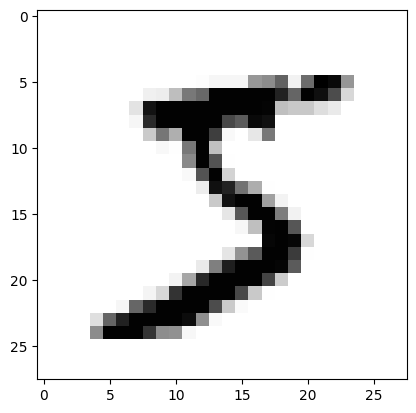

In [5]:
import matplotlib.pyplot as plt
from matplotlib import colormaps

plt.imshow(X_train[0], cmap=colormaps.get("Greys"));

Cada imagen se compone de 28x28 pixeles, y cada pixel representa una escala de grises que va del 0 al 255. Siendo 0 el blanco y 255 negro.

Sabemos que las redes neuronales son [muy susceptibles](../M2%20-%20Fundamentos%20de%20ML/M2.1%20Familias%20de%20modelos/5.%20Redes%20neuronales.ipynb) a la escala de los datos de entrada, así que los normalizaremos dividiendo por el valor máximo y así los dejaremos en una escala del 0 al 1.

In [6]:
X_train = X_train.astype("float32")/255
X_test = X_test.astype("float32")/255

In [7]:
np.mean(X_train)

np.float32(0.13066047)

In [8]:
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

Deberemos reservar algunos datos para validar el progreso de nuestra red. Esto indica que existen tres conjuntos de datos que son los que empleamos para:

* **Train** Entrenar la red
* **Valid** Validar si vamos por buen camino
* **Test** Evaluar al finalizar nuestro entrenamiento

Estos datos se usarán durante el entrenamiento. Otra opción es decirle a Keras en la etapa de entrenamiento que reserve un X % de los datos para validar.

In [9]:
validation = 10000

X_val = X_train[-validation:]
y_val = y_train[-validation:]

X_train = X_train[:-validation]
y_train = y_train[:-validation]

In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


## Arquitectura

Montamos la arquitectura de la red neuronal. Se va a componer de:
* **Sequential**: API para iniciar la red neuronal. No cuenta como capa.
* **Flatten**: capa de entrada. Necesita un vector unidimensional. Como tenemos imágenes, esta capa aplana las imágenes (2D) en 1D.
* **Dense**: es una hidden layer. Se compondrá de `n` neuronas y de una función de activación que se aplicará a todas las neuronas de la capa.

En cuanto a las funciones de activación es recomendable usar `relu` en las hidden layer, que tarda menos en entrenar. En nuestro caso, tenemos 10 categorías que deberán arrojar la probabilidad de pertenencia en cada caso. Esto nos indica que deberemos usar 10 neuronas con una activación `softmax` que garantiza que la suma de todas las probabilidades queda limitada a 1.

[Función softmax](https://es.wikipedia.org/wiki/Funci%C3%B3n_SoftMax)

In [11]:
X_train.shape

(50000, 28, 28)

In [12]:
model = keras.models.Sequential()

# Capa entrada
model.add(keras.layers.Input((28, 28)))
model.add(keras.layers.Flatten())

# Hidden layer
model.add(keras.layers.Dense(units = 300,
                            activation='relu'))

# Hidden layer
model.add(keras.layers.Dense(units = 100,
                            activation='relu'))

# Capa salida
model.add(keras.layers.Dense(units = 10,
                            activation='softmax'))

I0000 00:00:1759683260.649384  622194 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4023 MB memory:  -> device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
# Otra manera de declarar la red neuronal
capas = [
    keras.layers.Input((28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 300, activation='relu'),
    keras.layers.Dense(units = 100, activation='relu'),
    keras.layers.Dense(units = 10, activation='softmax')
]

model = keras.models.Sequential(capas)

Aunque las capas intermedias pueden tener formas arbitrarias, existen dos limitaciones:

* La capa de entrada que deberá tener tantas entradas como datos numéricos manejemos
* La capa de salida que deberá adecuarse a la tareas y posibles clases a predecir

Veamos que pinta tiene la estructura de la red.

In [14]:
print(model.layers[0])

<Flatten name=flatten_1, built=True>


Podemos ver los pesos de las capas sin entrenar, porque los inicializa aleatoriamente. Los bias los inicializa a 0 dado que aún desconocemos cómo debemos afectar a toda la capa de igual modo.

In [15]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
weights

array([[-0.02984926, -0.0684329 , -0.03914489, ...,  0.07360554,
         0.00170243, -0.07180613],
       [ 0.06369625,  0.06981888,  0.00151673, ...,  0.04275323,
         0.07363778, -0.03750646],
       [-0.0193481 ,  0.00066488,  0.05960518, ..., -0.01263802,
         0.05720265,  0.06402741],
       ...,
       [-0.02615722,  0.03286647,  0.01326267, ..., -0.01397725,
         0.01156343, -0.03916147],
       [-0.00309031, -0.07073443,  0.0710769 , ...,  0.02589035,
        -0.03049077, -0.04211332],
       [-0.00732662,  0.03516388, -0.05021455, ...,  0.00997465,
         0.04482709,  0.04893877]], shape=(784, 300), dtype=float32)

Podemos ver que el tamaño de la capa coincide con las entradas y neuronas a las que conectar en la segunda capa (Dense).

In [16]:
weights.size == (28*28)*300

True

In [17]:
len(biases) == 300

True

Esta arquitectura es completamente arbitraria, ya que desconocemos que número de capas y neuronas serán las que den mejor resultado. Podemos considerarlo parte de los hiperparámetros del modelo.

El método de compilación determina aspectos clave para entrenar nuestra estructura como:

* El optimizador a emplear
* La función de pérdida/coste que guiará el entrenamiento
* Métricas resultado que queramos arrojar adicionalmente 

In [18]:
model.compile(
    optimizer = keras.optimizers.SGD(),
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)

In [19]:
# Equivalente
model.compile(
    optimizer = "sgd",
    loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"]
)

In [20]:
# Summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

La 1º neurona de la 1º hidden layer
$$
y = a + w_1*x_1 + w_2*x_2 + .... w_n*x_n
$$

donde $a$ es el intercepto llamado bias, $w_n$ es cada uno de los pesos que va a ir actualizando con la retropropagación del error y $n$ es 784.

Por tanto, en la 1º hidden layer tenemos 784 pesos por cada neurona, al tener 300, tenemos un total de:

In [21]:
print(784*300 + 300)

235500


Entrenamos el modelo. Usamos los datos de entrenamiento. El batch_size es la cantidad de muestras que utiliza el SGD, y las epochs son las iteraciones que realiza en el entrenamiento.

In [22]:
X_train.shape

(50000, 28, 28)

## Entrenamiento

In [23]:
history = model.fit(
    X_train,
    y_train,
    batch_size = 128,
    epochs = 50,
    validation_data = (X_val, y_val) # validation_split = 0.1
)

Epoch 1/50


2025-10-05 18:54:48.990360: I external/local_xla/xla/service/service.cc:163] XLA service 0x717ac8015ae0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-05 18:54:48.990375: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A3000 Laptop GPU, Compute Capability 8.6
2025-10-05 18:54:49.005334: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-05 18:54:49.051146: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91301
2025-10-05 18:54:49.067729: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:54:49.067784:

142/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3718 - loss: 2.0447

I0000 00:00:1759683291.852043  623428 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


358/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5316 - loss: 1.7002

2025-10-05 18:54:52.358037: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:54:52.358096: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:54:52.634434: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_45', 8 bytes spill stores, 8 bytes spill loads

2025-10-05 18:54:53.080099: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.7162 - loss: 1.1876 - val_accuracy: 0.8750 - val_loss: 0.5614
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8749 - loss: 0.4926 - val_accuracy: 0.9010 - val_loss: 0.3802
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8943 - loss: 0.3862 - val_accuracy: 0.9116 - val_loss: 0.3254
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9057 - loss: 0.3405 - val_accuracy: 0.9168 - val_loss: 0.2966
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9123 - loss: 0.3122 - val_accuracy: 0.9223 - val_loss: 0.2760
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9178 - loss: 0.2911 - val_accuracy: 0.9275 - val_loss: 0.2610
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9221 - loss: 0.2748 - val_accuracy: 0.9287 - val_loss: 0.2502
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9261 - loss: 0.2609 - val_accuracy: 0.9328 - val

Podemos reentrenar el modelo. No empieza de nuevo, si no que retoma el entrenamiento anterior y sigue iterando buscando un mejor ajuste. Aquí es clave el balance entre conjunto de entrenamiento y validación para que no se ajuste demasiado a los datos mostrados y aprenda a generalizar.

In [24]:
model.fit(
    X_train,
    y_train,
    batch_size = 64,
    epochs = 10,
    validation_data = (X_val, y_val) # validation_split = 0.1
)

Epoch 1/10


2025-10-05 18:55:50.747199: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:55:50.747258: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:55:50.747308: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:55:51.824406: I external/l

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9778 - loss: 0.0818 - val_accuracy: 0.9713 - val_loss: 0.1035
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9785 - loss: 0.0789 - val_accuracy: 0.9710 - val_loss: 0.0999
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9796 - loss: 0.0757 - val_accuracy: 0.9718 - val_loss: 0.0992
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9804 - loss: 0.0731 - val_accuracy: 0.9727 - val_loss: 0.0961
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9806 - loss: 0.0706 - val_accuracy: 0.9715 - val_loss: 0.0978
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9815 - loss: 0.0680 - val_accuracy: 0.9732 - val_loss: 0.0946
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9822 - loss: 0.0658 - val_accuracy: 0.9731 - val_loss: 0.0939
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9831 - loss: 0.0636 - val_accuracy: 0.9739 - val_

Veamos el histórico del entrenamiento, para poder representarlo posteriormente.

In [25]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,accuracy,loss,val_accuracy,val_loss
0,0.71622,1.187629,0.8750,0.561397
1,0.87486,0.492606,0.9010,0.380241
2,0.89432,0.386236,0.9116,0.325394
3,0.90568,0.340488,0.9168,0.296638
4,0.91228,0.312219,0.9223,0.276013


In [27]:
hist_df.tail()

,accuracy,loss,val_accuracy,val_loss
45,0.97568,0.089248,0.9705,0.107998
46,0.97630,0.087547,0.9710,0.106467
47,0.97680,0.085581,0.9704,0.105408
48,0.97746,0.084004,0.9701,0.105040
49,0.97788,0.082377,0.9708,0.103684


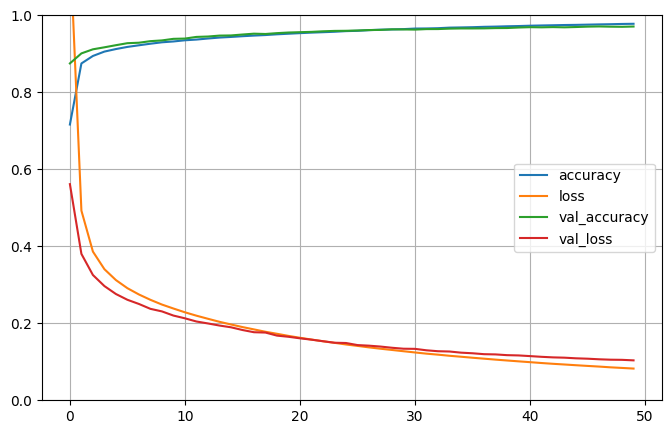

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

Si el modelo no ha ido bien, prueba a cambiar el **learning rate**, cambia de optimizador y después prueba a cambiar capas, neuronas y funciones de activación.

## Evaluación

Ya tenemos el modelo entrenado. Veamos que nos dice en evaluación.

In [29]:
results = model.evaluate(X_test, y_test)
results

2025-10-05 18:56:16.833582: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-05 18:56:17.689535: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_34', 52 bytes spill stores, 52 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - accuracy: 0.9731 - loss: 0.0868


[0.08679783344268799, 0.9731000065803528]

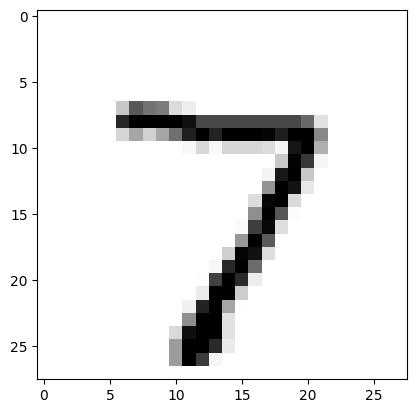

In [30]:
# Cogemos el primero
plt.imshow(X_test[0].reshape(28,28), cmap=colormaps.get("Greys"));

In [31]:
predictions = model.predict(X_test[:1])
print(predictions.shape)
np.round(predictions,2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
(1, 10)


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], dtype=float32)

In [32]:
predictions[0,7]

np.float32(0.9976615)

In [33]:
predictions.argmax()

np.int64(7)

In [34]:
predictions = model.predict(X_test).argmax(axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


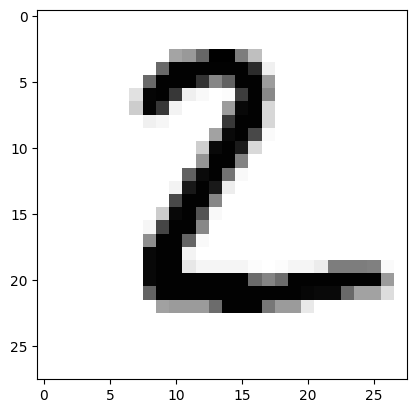

In [35]:
plt.imshow(X_test[1].reshape(28,28), cmap=colormaps.get("Greys"));

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, predictions)

array([[ 968,    0,    1,    1,    2,    1,    4,    1,    2,    0],
       [   0, 1122,    2,    1,    0,    1,    3,    0,    6,    0],
       [   6,    1, 1004,    4,    3,    0,    1,    5,    8,    0],
       [   0,    0,    5,  986,    0,    5,    0,    6,    6,    2],
       [   2,    0,    5,    0,  958,    0,    3,    2,    1,   11],
       [   3,    0,    0,    8,    2,  861,    7,    1,    8,    2],
       [   7,    3,    2,    1,    5,    6,  931,    0,    3,    0],
       [   1,    9,    9,    2,    0,    0,    0,  996,    4,    7],
       [   3,    1,    3,    8,    3,    5,    4,    3,  943,    1],
       [   4,    5,    1,    9,   16,    2,    1,    6,    3,  962]])

In [37]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       980
         1.0       0.98      0.99      0.99      1135
         2.0       0.97      0.97      0.97      1032
         3.0       0.97      0.98      0.97      1010
         4.0       0.97      0.98      0.97       982
         5.0       0.98      0.97      0.97       892
         6.0       0.98      0.97      0.97       958
         7.0       0.98      0.97      0.97      1028
         8.0       0.96      0.97      0.96       974
         9.0       0.98      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Problema de regresión

Veamos un ejemplo de cómo aplicar una red neuronal de TensorFlow a un problema de regresión. En este caso deberemos hacer que nuestra red sea capaz de emitir un número como salida a unas entradas dadas.

## Datos

In [38]:
# Cargamos datos
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
df = pd.DataFrame(housing.data, columns = housing.feature_names)
df['target'] = housing['target']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Dividimos en train, test y validation. También aplicaremos un escalado a los datos para acotarlos a valores centrados en cero.

In [39]:
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data,
                                                              housing.target)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [40]:
X_train.shape

(11610, 8)

# Arquitectura

Sabemos que disponemos de 8 entradas (neuronas) y  una neurona de salida que podrá tomar cualquier valor. Queda en nuestra mano decidir la estructura central.

In [41]:
# Modelo con una capa oculta
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = X_train.shape[1:]),
    keras.layers.Dense(1)
])

# Compilado con pérdida y optimización
model.compile(loss = "mean_squared_error", optimizer = "sgd")

# Entrenamiento
history = model.fit(X_train,
                   y_train,
                   epochs = 20,
                   validation_data = (X_valid, y_valid))

Epoch 1/20


/home/david/Vídeos/2025-09-STEMIA/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.0584 - val_loss: 0.5107
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5109 - val_loss: 0.4743
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4747 - val_loss: 0.4520
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4576 - val_loss: 0.4457
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4833 - val_loss: 0.4422
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4462 - val_loss: 0.4273
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4350 - val_loss: 0.4184
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4303 - val_loss: 0.4120
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4251 - val_loss: 0.4113
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4233 - val_loss: 0.4055
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4189 - val_loss: 0.4022
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [42]:
history = model.fit(X_train,
                   y_train,
                   epochs = 5,
                   validation_data = (X_valid, y_valid))

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3865 - val_loss: 0.3721
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4088 - val_loss: 0.3685
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3824 - val_loss: 0.3683
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3824 - val_loss: 0.3643
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 0.3801 - val_loss: 0.3679


In [43]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 303 (1.19 KB)

 Trainable params: 301 (1.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

La función evaluate devuelve las métricas de perdida y adicionales para poder así comparar con los valores obtenidos en entrenamiento.

In [44]:
mse_test = model.evaluate(X_test, y_test)
print(mse_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3686 
0.36861854791641235


Una vez entrenado podremos simplemente llamar a la función predict.

In [45]:
y_pred = model.predict(X_test)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


### Guardar modelo
Para guardar el modelo, en el formato de Keras (HDF5), optimizado para estructuras pesadas disponemos de una función `save`al igual que una función `load` para cargar modelos ya entrenados.

In [46]:
model.save("my_keras_model.keras")

In [47]:
# Lo volvemos a cargar
model = keras.models.load_model("my_keras_model.keras")

### Callbacks
Son funciones predefinidas de Keras a aplicar durante el entrenamiento
Por ejemplo, `ModelCheckpoint` sirve para que el modelo se vaya guardando tras cada epoch. Así no perdemos el progreso en caso de que decidamos interrumpir el entrenamiento. El callback recibe como argumento el nombre del objeto donde queremos que se guarde el modelo entrenado.

In [48]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("callback_model.keras")

history = model.fit(X_train,
                   y_train,
                   epochs=30,
                   callbacks = [checkpoint_cb])

Epoch 1/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3784 
Epoch 2/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 747us/step - loss: 0.3781
Epoch 3/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 0.3773
Epoch 4/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 0.3760
Epoch 5/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 772us/step - loss: 0.3706
Epoch 6/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.3762
Epoch 7/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 0.3677
Epoch 8/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - loss: 0.3688
Epoch 9/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 0.3733
Epoch 10/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 0.3779
Epoch 11/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 0.3718
Epoch 12/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 0.3664
Epoch 13/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 0.3679
Epoch 14/30
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 0.3608
Epoch 15/30
363/363 ━━━━━━━━━━

### Early Stopping
Interrumpe el entrenamiento cuando no ve progreso en el set de validación. Para ello tiene en cuenta un numero de epochs llamado `patience`. Se puede combinar con el callback

In [49]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10)
history = model.fit(X_train,
                   y_train,
                   epochs=50,
                   validation_data = (X_valid, y_valid),
                   callbacks = [early_stopping_cb, checkpoint_cb])

Epoch 1/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3406 - val_loss: 0.3329
Epoch 2/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3391 - val_loss: 0.3270
Epoch 3/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3395 - val_loss: 0.3289
Epoch 4/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3373 - val_loss: 0.3269
Epoch 5/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3372 - val_loss: 0.3220
Epoch 6/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3362 - val_loss: 0.3331
Epoch 7/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3437 - val_loss: 0.3300
Epoch 8/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3382 - val_loss: 0.3263
Epoch 9/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3368 - val_loss: 0.3234
Epoch 10/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3346 - val_loss: 0.3299
Epoch 11/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.3334 - val_loss: 0.3335
Epoch 12/50
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step